<a href="https://colab.research.google.com/github/pnjha/NLP-Assignments/blob/master/nlp_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 48kB/s 
     |████████████████████████████████| 419kB 42.1MB/s 
     |████████████████████████████████| 3.0MB 47.4MB/s 


In [1]:
import unicodedata
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import *
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import copy
import math
import seaborn as sns; sns.set()
import keras as keras
from keras.optimizers import SGD
from keras.initializers import RandomUniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout, Activation, dot, concatenate, Bidirectional
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [4]:
X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.en', names=['src'])
Y_in = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_in'])
Y_out = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_out'])
lines = pd.concat([X[:100],Y_in[:100],Y_out[:100]], axis=1)
print(len(lines))
# lines = shuffle(lines)
lines.sample(10)

100


,src,dest_in,dest_out
56,Due to changes in our lifestyle the number of ...,वैसे-वैसे अपने जीवन की शैली में बदलाव के कारण ...,वैसे-वैसे अपने जीवन की शैली में बदलाव के कारण ...
53,"Cancer erupts by our wrong practices , thought...","कैंसर हमारे गलत अचार , विचार व्यवहार और आहार स...","कैंसर हमारे गलत अचार , विचार व्यवहार और आहार स..."
96,Cancer of the cervix is a common cancer of occ...,ग्रीवा का कैंसर स्त्रियों में होने वाला एक आम ...,ग्रीवा का कैंसर स्त्रियों में होने वाला एक आम ...
7,In black cataract the eye nerves dilapidates g...,काला मोतियाबिंद में नेत्र तंत्रिका धीरे -धीरे ...,काला मोतियाबिंद में नेत्र तंत्रिका धीरे -धीरे ...
23,It is visible in dim light .,कम रोशनी में दिखाई देता है ।,कम रोशनी में दिखाई देता है ।
55,We progress towards development and getting ri...,जैसे-जैसे हम विकास की ओर अग्रसर हो रहे है एवं ...,जैसे-जैसे हम विकास की ओर अग्रसर हो रहे है एवं ...
35,Gradual and painless lessening of vision in on...,धीरे-धीरे तथा बिना दर्द के एक या दोनों आँखों म...,धीरे-धीरे तथा बिना दर्द के एक या दोनों आँखों म...
76,Several symptoms shows up due to cancer that g...,कैंसर के कारण ऐसे अनेक लक्षण दिखलाई पड़ने लगते...,कैंसर के कारण ऐसे अनेक लक्षण दिखलाई पड़ने लगते...
97,Among all the cancers occurring in India 40 pe...,भारत में औरतों में होने वाले कुल कैंसर रोगों म...,भारत में औरतों में होने वाले कुल कैंसर रोगों म...
98,Lymph nodes are connected to lymph arteries an...,लसीका ग्रन्थियाँ लसीका धमनियों द्वारा एक दूसरे...,लसीका ग्रन्थियाँ लसीका धमनियों द्वारा एक दूसरे...


In [0]:
def process_data(data,append_char):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: x.strip())
    data = data.apply(lambda x: re.sub("'", '', x))
    exclude = set(string.punctuation) # Set of all special characters
    data = data.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    remove_digits = str.maketrans('', '', digits)
    data = data.apply(lambda x: x.translate(remove_digits))
    if append_char == 1:
        data = data.apply(lambda x : '<sos> '+ x)
    elif append_char == 2:
        data = data.apply(lambda x : x + ' <eos>')
    return data

In [6]:
lines.src = process_data(lines.src,0)
lines.dest_in = process_data(lines.dest_in,1)
lines.dest_out = process_data(lines.dest_out,2)
lines.src.sample(10),lines.dest_in.sample(10),lines.dest_out.sample(10)

(84                  change in general habits of bowels 
 2     during operation lens is implanted at front of...
 42    the patient can see nearby things clearly but ...
 79           any wound that do not heal in enough time 
 13    main symptoms on appearance of which a patient...
 72    difficult tumors can destroy nearby tissues an...
 87    therefore one should not take it as cancer jus...
 28             applying vaccine at the time of measles 
 37    when the rays of light do not fall on the reti...
 4                   lens is fitted in the capsular bag 
 Name: src, dtype: object,
 88    <sos> दो सप्ताह तक इन लक्षणों के बने रहने पर इ...
 23                   <sos> कम रोशनी में दिखाई देता है ।
 24                    <sos> स्वेत पटल सूखा हो जाता है ।
 26    <sos> रतौंधी से बचने के लिए चौलाई  चने का साग ...
 90    <sos> आवश्यकता है  इसके बारे में जानकारी बढ़ाने...
 62    <sos> पुरूषों में धूम्रपान एवं प्रदूषण से फेफड़...
 19    <sos> विटामिनए की कमी खसरे तथा कुपोषण की स्थित...
 13 

In [0]:
def get_max_sentence_size(data):
    max_len = 0
    for line in data:
        line = line.strip()
        temp = line.split()
        max_len = max(max_len, len(temp))
    return max_len

In [27]:
src_max_len = get_max_sentence_size(lines.src)
dest_max_len = get_max_sentence_size(lines.dest_in)
src_max_len,dest_max_len

(42, 40)

In [0]:
X, y_in, y_out = lines.src.values, lines.dest_in.values, lines.dest_out.values 
X_train, X_test, y_in_train, y_in_test, y_out_train, y_out_test = train_test_split(X, y_in, y_out, test_size = 0.2,shuffle=False)

In [0]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
src_tokenizer.fit_on_texts(X_train)

data_src = src_tokenizer.texts_to_sequences(X_train)
data_src = tf.keras.preprocessing.sequence.pad_sequences(data_src,padding='post')

# print(src_tokenizer.word_index)
# print(data_src)
# print(len(data_src[0]))

In [30]:
dest_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

dest_tokenizer.fit_on_texts(y_in_train)
dest_tokenizer.fit_on_texts(y_out_train)

data_dest_in = dest_tokenizer.texts_to_sequences(y_in_train)
data_dest_in = tf.keras.preprocessing.sequence.pad_sequences(data_dest_in,padding='post')

data_dest_out = dest_tokenizer.texts_to_sequences(y_out_train)
data_dest_out = tf.keras.preprocessing.sequence.pad_sequences(data_dest_out,padding='post')

print(data_dest_in.shape)
print(data_dest_out.shape)

(80, 40)
(80, 40)


In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm_1(embed, initial_state=states)
        output, state_h, state_c = self.lstm_2(output, initial_state=[state_h,state_c])
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

In [0]:
class LuongAttention(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class LuongAttentionDot(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttentionDot, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        # Dot score: h_t (dot) Wa (dot) h_s
        # encoder_output shape: (batch_size, max_len, lstm_size)
        # decoder_output shape: (batch_size, 1, lstm_size)
        # score will have shape: (batch_size, 1, max_len)
        score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, lstm_size):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(lstm_size)
    self.W2 = tf.keras.layers.Dense(lstm_size)
    self.V = tf.keras.layers.Dense(1)

  def call(self, decoder_output, encoder_output):
    
    score = self.V(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output)))
    score = tf.transpose(score,perm=[0,2,1])
    
    attention_weights = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(attention_weights, encoder_output)

    return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size, attn_type):
        super(Decoder, self).__init__()

        if attn_type == 'LuongAttention':
          self.attention = LuongAttention(lstm_size)
        elif attn_type == 'LuongAttentionDot':
          self.attention = LuongAttentionDot(lstm_size)
        elif attn_type == 'BahdanauAttention':
          self.attention = BahdanauAttention(lstm_size)
        
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(lstm_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, state, encoder_output):

        embed = self.embedding(sequence)
        
        lstm_out, state_h, state_c = self.lstm_1(embed, initial_state=state)
        lstm_out, state_h, state_c = self.lstm_2(lstm_out, initial_state=[state_h,state_c])
        context, alignment = self.attention(lstm_out, encoder_output)

        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        lstm_out = self.wc(lstm_out)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [0]:
BATCH_SIZE = 20
EMBEDDING_SIZE = 256
LSTM_SIZE = 256

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((data_src, data_dest_in, data_dest_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)
print(dataset)

<BatchDataset shapes: ((None, 42), (None, 40), (None, 40)), types: (tf.int32, tf.int32, tf.int32)>


In [0]:
def get_model(attn_type):
  src_vocab_size = len(src_tokenizer.word_index) + 1
  dest_vocab_size = len(dest_tokenizer.word_index) + 1

  encoder = Encoder(src_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)
  decoder = Decoder(dest_vocab_size, EMBEDDING_SIZE, LSTM_SIZE,attn_type)
  return encoder, decoder

In [0]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = crossentropy(targets, logits)
    return loss

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [0]:
def train_step(model,source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    encoder = model["encoder"]
    decoder = model["decoder"]
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states
        
        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
            
            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

In [0]:
def predict(model,test_source_text):
    test_source_seq = src_tokenizer.texts_to_sequences([test_source_text])

    encoder = model["encoder"]
    decoder = model["decoder"]

    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

    de_input = tf.constant([[dest_tokenizer.word_index['<sos>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    alignments = []

    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        try:
          out_words.append(dest_tokenizer.index_word[de_input.numpy()[0][0]])
        except:
          out_words.append('<unk>')
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= dest_max_len:
            break

    out_words = ' '.join(out_words)
    return np.array(alignments), out_words

In [0]:
def train_model(attn_type,NUM_EPOCHS):
  encoder, decoder = get_model(attn_type)
  model = {"encoder":encoder,"decoder":decoder}
  loss_list = []
  ep_list = []
  for e in range(NUM_EPOCHS):
      en_initial_states = encoder.init_states(BATCH_SIZE)

      for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
          loss = train_step(model, source_seq, target_seq_in,target_seq_out, en_initial_states)
      
      ep_list.append(e+1)
      loss_list.append(loss.numpy())
      print('Epoch {} Loss {:.8f}'.format(e + 1, loss.numpy()))
  return encoder, decoder, loss_list, ep_list

In [0]:
def calculate_bleu_score(actual_string, predicted_string):
    actual_string = copy.deepcopy(actual_string)
    predicted_string = copy.deepcopy(predicted_string)
    reference = re.split("\s",actual_string.strip())
    candidate = re.split("\s",predicted_string.strip())
    try:
      reference.remove('<eos>')
      candidate.remove('<sos>')
    except:
      pass
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return score

In [0]:
def plot_graph(xlist,ylist,xname,yname):
  x = np.array(xlist)
  y = np.array(ylist)
  d = {xname: x, yname: y}
  data = pd.DataFrame(d)
  sns.lineplot(x=xname, y=yname,data = data)
  plt.show()

In [0]:
def get_prediction(X,y,model):
  for index,line in enumerate(X):
    alignment, output = predict(model,line)
    print("source: ",line)
    print("actual: ",y[index])
    print("predicted: ",output)
    print("BLEU Score: ",calculate_bleu_score(output,y[index]))
    ax = sns.heatmap(alignment[:,0,0,:],linewidths=.2,cmap="YlGnBu")
    # print(type(alignment))
    # print(alignment[:,0,0,:])
    plt.show()

Epoch 1 Loss 9.43123436
Epoch 2 Loss 4.37391424
Epoch 3 Loss 3.81709671
Epoch 4 Loss 3.34667850
Epoch 5 Loss 4.59530067
Epoch 6 Loss 3.21672368
Epoch 7 Loss 3.13313866
Epoch 8 Loss 3.00249839
Epoch 9 Loss 2.79663849
Epoch 10 Loss 2.64980650
Epoch 11 Loss 2.50824952
Epoch 12 Loss 2.62876654
Epoch 13 Loss 2.40303755
Epoch 14 Loss 2.41486049
Epoch 15 Loss 2.23056817
Epoch 16 Loss 2.18329000
Epoch 17 Loss 2.09795332
Epoch 18 Loss 2.01960230
Epoch 19 Loss 1.94333899
Epoch 20 Loss 1.88109434
Epoch 21 Loss 1.82686973
Epoch 22 Loss 1.80961764
Epoch 23 Loss 1.96072555
Epoch 24 Loss 1.87594473
Epoch 25 Loss 1.68446040
Epoch 26 Loss 1.59190977
Epoch 27 Loss 1.57248271
Epoch 28 Loss 1.50908506
Epoch 29 Loss 1.40247238
Epoch 30 Loss 1.35679042
Epoch 31 Loss 1.32315981
Epoch 32 Loss 1.26584721
Epoch 33 Loss 1.30427957
Epoch 34 Loss 1.27353060
Epoch 35 Loss 1.12151921
Epoch 36 Loss 1.08746588
Epoch 37 Loss 1.02529109
Epoch 38 Loss 0.98308742
Epoch 39 Loss 0.94328701
Epoch 40 Loss 0.84781420
Epoch 41 

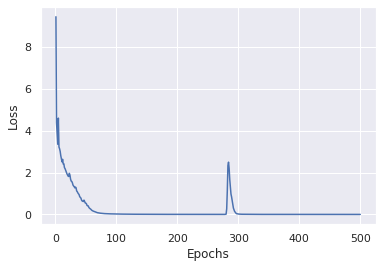

In [47]:
attn_type = 'BahdanauAttention'
# attn_type = 'LuongAttentionDot'
# attn_type = 'LuongAttention'
NUM_EPOCHS = 500
encoder, decoder, loss_list,epoch_list = train_model(attn_type,NUM_EPOCHS)
plot_graph(epoch_list,loss_list,"Epochs","Loss")

source:  the treatment of cataract is possible through surgery only 
actual:  <sos> मोतियाबिंद का उपचार केवल शल्यचिकित्सा द्वारा ही सम्भव है ।
predicted:  मोतियाबिंद का उपचार केवल टीके समय वाली अधिक होता है । <eos>
BLEU Score:  0.19552795980276136


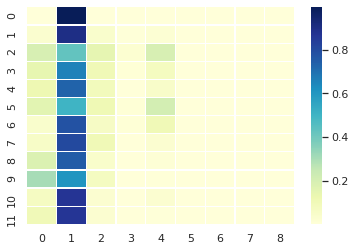

source:  complete lens capsule is taken out in the method of intra capsular cataract extraction  after the operation spectacles are used posttest 
actual:  <sos> इन्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन  intra capsular cataract extraction  विधि में पूरा लैन्स कैपस्यूल निकाला जाता है  ऑपरेशन के बाद जाँच के उपरान्त चश्में का प्रयोग किया जाता है ।
predicted:  इन्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन intra capsular cataract extraction विधि में पूरा लैन्स कैपस्यूल निकाला जाता है । <eos>
BLEU Score:  0.1700626446369399


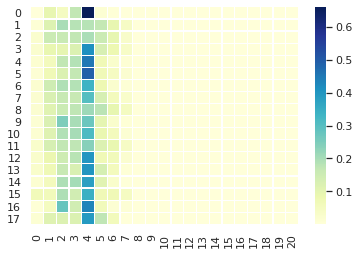

source:  during operation lens is implanted at front of the iris  the frontal part of the eye 
actual:  <sos> ऑपरेशन के दौरान लैन्स प्रत्यारोपण आँख के अगले भाग  आइरिस के आगे किया जाता है ।
predicted:  ऑपरेशन के दौरान लैन्स प्रत्यारोपण आँख के अगले भाग आइरिस के आगे किया जाता है । <eos>
BLEU Score:  0.18557819854739144


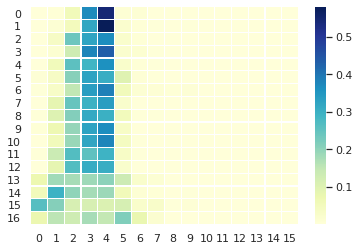

source:  in the extra capsular cataract method  the part of the frontal capsule and the whole of the lens matter is extracted and the posterior part of the capsule is left intact 
actual:  <sos> इक्स्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन विधि में सामने वाला कैपस्यूल का हिस्सा तथा पूरा लैन्स मैटर निकाल लिया जाता है और पीछे वाला कैपस्यूल सुरक्षित छोड़ दिया जाता है ।
predicted:  इक्स्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन विधि में सामने वाला कैपस्यूल का हिस्सा तथा पूरा लैन्स मैटर निकाल लिया जाता है और पीछे वाला कैपस्यूल सुरक्षित छोड़ दिया जाता है । <eos>
BLEU Score:  0.17261970532895454


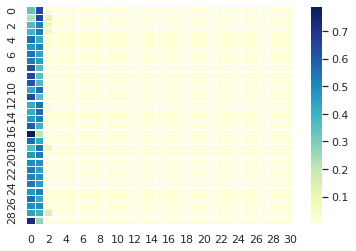

source:  lens is fitted in the capsular bag 
actual:  <sos> कैपस्यूलर बैग में लैन्स फिट किया जाता है ।
predicted:  कैपस्यूलर बैग में बीमारी हो जाता है । <eos>
BLEU Score:  0.1969244213551724


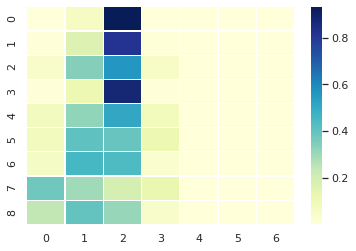

source:  in the s     lrb small incision cataract surgery rrb method   mm tunnel is formed while the rest of the method follows like that of the ecceiol 
actual:  <sos> sics  small incision cataract surgry  विधि में  मिमी की एक टनल बनाई जाती है शेष विधि ecce–iol की तरह होती है ।
predicted:  sics small incision cataract surgry विधि में मिमी की एक टनल बनाई जाती है । <eos>
BLEU Score:  0.17639910709395284


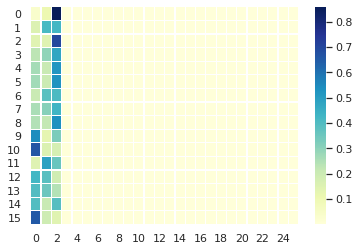

source:  no stitches are applied in the s     lrb small incision cataract surgery rrb method 
actual:  <sos> sics  small incision cataract surgry  विधि में टाँके नही लगाये जाते हैं ।
predicted:  sics small incision cataract surgry विधि में टाँके नही लगाये जाते हैं । <eos>
BLEU Score:  0.18827362913939635


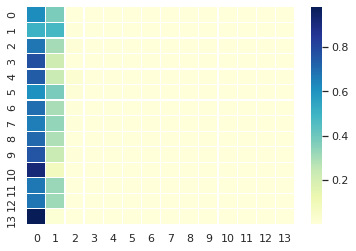

source:  in black cataract the eye nerves dilapidates gradually  it happens due to extra water pressure in the eye or because of not enough blood reaching in the eye nerves 
actual:  <sos> काला मोतियाबिंद में नेत्र तंत्रिका धीरे धीरे नष्ट होती है आँख में पानी का दबाव ज्यादा होने की वजह से या नेत्र तंत्रिका में रक्त पर्याप्त मात्रा में न पहुँचने की वजह से ऐसा होता है ।
predicted:  काला मोतियाबिंद में नेत्र तंत्रिका धीरे धीरे नष्ट होती है आँख में पानी का दबाव ज्यादा होने की वजह से या नेत्र तंत्रिका में रक्त पर्याप्त मात्रा में न पहुँचने की वजह से ऐसा होता है । <eos>
BLEU Score:  0.1976899956120945


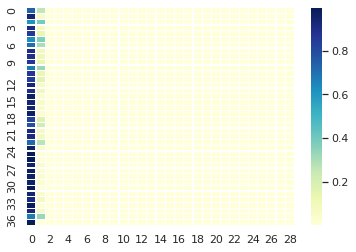

source:  the blindness caused by the black cataract can be prevented if it is identified soon and its regular treatment and tests continue 
actual:  <sos> काले मोतियाबिंद से होने वाली अधंता अंधता को रोका जा सकता है यदि इसका पता जल्दी लग जाए तथा इसका नियमित इलाज व जाँच होती रहे ।
predicted:  काले मोतियाबिंद से होने वाली अधंता अंधता को रोका जा सकता है यदि इसका नियमित इलाज व जाँच होती रहे । <eos>
BLEU Score:  0.20745969231372235


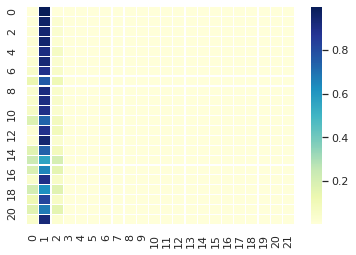

source:  when the extra pressure is more in the eyes 
actual:  <sos> जब आँखों में अतिरिक्त दबाव ज्यादा हो ।
predicted:  जब आँखों में अतिरिक्त दबाव ज्यादा हो । <eos>
BLEU Score:  0.19817632389021378


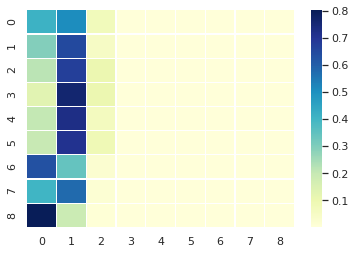

source:  if somebody suffers from black cataract in the family 
actual:  <sos> यदि परिवार में किसी को काला मोतियाबिंद हो ।
predicted:  यदि परिवार में किसी को से भरता नहीं हो । <eos>
BLEU Score:  0.1969244213551724


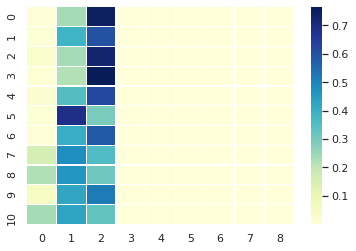

source:  in most of the patients the part of the water channel from the eyes are open yet for some reasons the water gets lessened 
actual:  <sos> अधिकांश मरीजों में आँख से पानी जाने का हिस्सा खुला होता है फिर भी कुछ कारणवस कारणवश पानी कम जाता है ।
predicted:  अधिकांश मरीजों में आँख से पानी जाने का हिस्सा खुला होता है फिर भी कुछ कारणवस कारणवश पानी कम जाता है । <eos>
BLEU Score:  0.17956076853248887


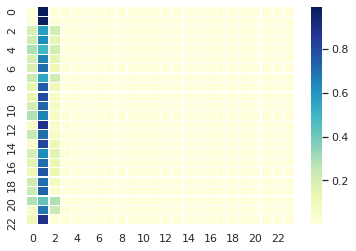

source:  internal pressure keeps on increasing and the eye nerves dilapidates  gradually the patient can not see things around  eyesight might also be lost if treatment is not done in time 
actual:  <sos> अंदर का दबाव बढ़ता जाता है और नेत्र तंत्रिका नष्ट होती है  धीरे  धीरे मरीज अगलबगल की चीजें नहीं देख पाता है  अगर समय पर इलाज न किया जाए तो नजर भी जा सकती है ।
predicted:  अंदर का दबाव बढ़ता जाता है और नेत्र तंत्रिका नष्ट होती है धीरे धीरे मरीज अगलबगल की चीजें नहीं देख पाता है अगर समय पर इलाज न किया जाए तो नजर भी जा सकती है । <eos>
BLEU Score:  0.19602553864933212


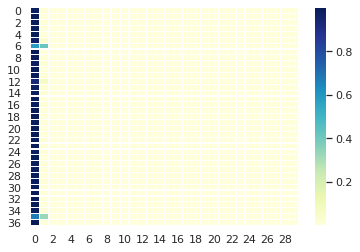

source:  main symptoms on appearance of which a patient should consult a doctor 
actual:  <sos> प्रमुख लक्षण जिनके प्रकट होने पर रोगी को डॉक्टर से जाँच करानी चाहिए ।
predicted:  प्रमुख लक्षण जिनके प्रकट होने पर रोगी को डॉक्टर से जाँच करानी चाहिए । <eos>
BLEU Score:  0.18968126713037053


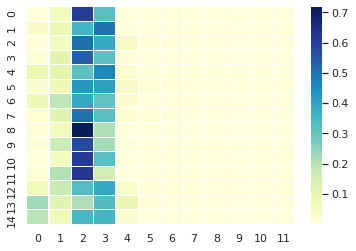

source:  seeing rainbow like colorful ovals in light 
actual:  <sos> रोशनी मे इंद्र धनुष के समान रंगीन गोले दिखाई देना ।
predicted:  रोशनी से परहेज बरतना फायदेमंद हो सकता है <eos>
BLEU Score:  0


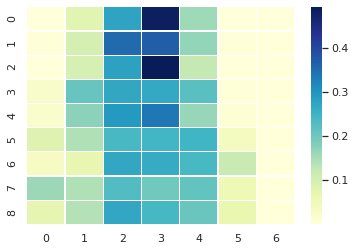

source:  we will check the eye nerves with special lens or equipment to find how much of damage has occurred 
actual:  <sos> विशेष लैन्स या यंत्र के द्वारा नेत्र तंत्रिका की जाँच करेंगे की कितनी क्षति पहुँची है ।
predicted:  विशेष लैन्स या यंत्र के द्वारा नेत्र तंत्रिका की जाँच करेंगे की कितनी क्षति पहुँची है । <eos>
BLEU Score:  0.18557819854739144


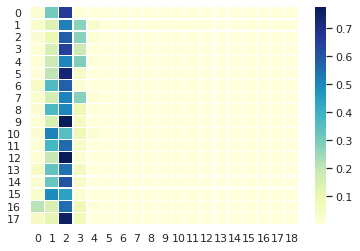

source:  field test  in which the capacity to see things on the sides while looking straight is tested 
actual:  <sos> फिल्ड टेस्ट जिसमें सामने देखते हुए साइड की चीजें देख सकने की क्षमता की जाँच होती है ।
predicted:  फिल्ड टेस्ट जिसमें सामने देखते हुए साइड की चीजें देख सकने की क्षमता की जाँच होती है । <eos>
BLEU Score:  0.18429333166740366


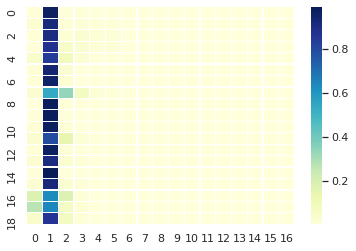

source:  the part lrb angle rrb from where the water passes out can be seen through a special lens 
actual:  <sos> एक विशेष लैन्स द्वारा पानी के बाहर जाने के हिस्से  एंगल  को देख सकते हैं ।
predicted:  एक विशेष लैन्स द्वारा पानी के बाहर जाने के हिस्से एंगल को देख सकते हैं । <eos>
BLEU Score:  0.18429333166740366


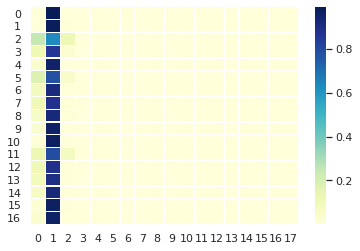

source:  with the lack of vitamina the cornea becomes weak and a wound appears through which at last causes blindness 
actual:  <sos> विटामिनए की कमी से कॉर्नियल कमजोर तथा घाव हो जाते हैं जिससे अन्त में अन्धापन होता है ।
predicted:  विटामिनए की कमी से कॉर्नियल कमजोर तथा घाव हो जाते हैं । <eos>
BLEU Score:  0.18429333166740366


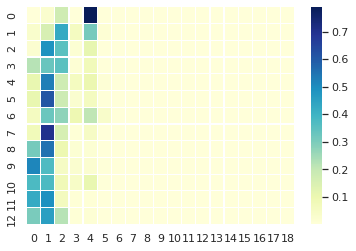

source:  the lack of vitamina is even more imminent in states of measles and malnutrition 
actual:  <sos> विटामिनए की कमी खसरे तथा कुपोषण की स्थिति में और अधिक होती है ।
predicted:  विटामिनए की कमी खसरे तथा कुपोषण में कुछ कारणवस कारणवश पर है । <eos>
BLEU Score:  0.18968126713037053


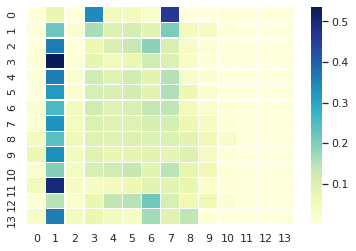

source:  nyctalopia may occur due to lack of vitamina 
actual:  <sos> विटामिनए की कमी से रतौंधी हो सकती है ।
predicted:  जापान में यह बीमारी दूसरे नम्बर पर और विकासशील देशों में यह तीसरे नम्बर पर है । <eos>
BLEU Score:  0.1969244213551724


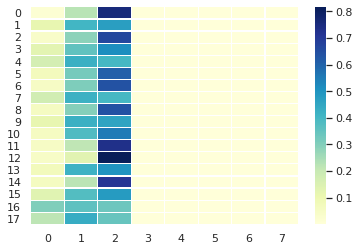

source:  absorption of vitamina during lack of vitamina in food  continuous diarrhoea and malnutrition 
actual:  <sos> खाने में विटामिनए की मात्रा की कमी लगातार दस्त तथा कुपोषण में विटामिनए का अवशोषण  absorption  कम होना ।
predicted:  खाने में विटामिनए की मात्रा की कमी लगातार दस्त है । <eos>
BLEU Score:  0.18068537884315472


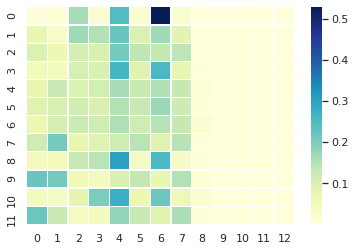

source:  demand of vitamina during and after measles 
actual:  <sos> खसरे के समय व बाद में विटामिनए की मांग का अधिक होना ।
predicted:  खसरे के समय पर किये जाने की आवश्यकता है । <eos>
BLEU Score:  0.2272851691411099


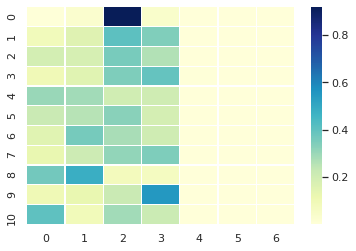

source:  it is visible in dim light 
actual:  <sos> कम रोशनी में दिखाई देता है ।
predicted:  कम रोशनी में काम है । <eos>
BLEU Score:  0.19913749124569236


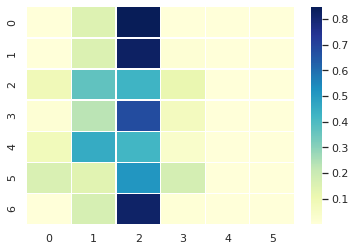

source:  white surface dries up 
actual:  <sos> स्वेत पटल सूखा हो जाता है ।
predicted:  स्वेत हो । <eos>
BLEU Score:  0.19913749124569236


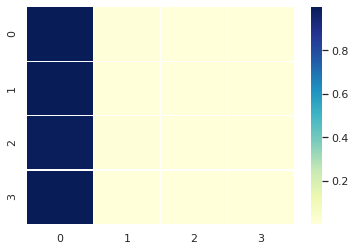

source:  bitot s spots  white spots shows up on white surface 
actual:  <sos> बिटोटस स्पॉट्स  श्वेत श्‍वेत पटल पर श्वेत श्‍वेत धब्बे दिखाई देते हैं ।
predicted:  बिटोटस स्पॉट्स श्वेत श्‍वेत हैं । <eos>
BLEU Score:  0.18968126713037053


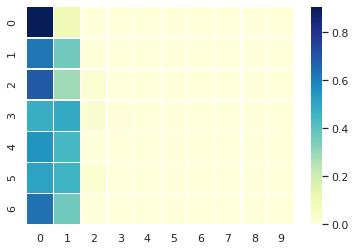

source:  use gram leaves  fenugreek or methi leaves  spinach  cabbage  coriander  papaya  mango in diet to prevent nyctalopia 
actual:  <sos> रतौंधी से बचने के लिए चौलाई  चने का साग  मैथी का साग  पालक  बन्दगोभी  धनिया  गाजर  पपीता  आम आदि का सेवन करें ।
predicted:  रतौंधी से बचने के लिए चौलाई चने का साग पालक बन्दगोभी धनिया गाजर पपीता आम आदि का सेवन करें । <eos>
BLEU Score:  0.17089108973983766


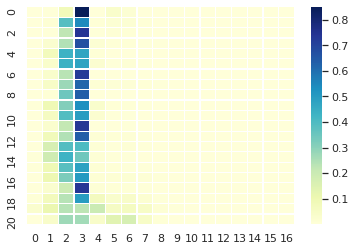

source:  encouraging mother for milk 
actual:  <sos> माँ को दूध के लिए प्रोत्साहित करना ।
predicted:  माँ हो सकने की क्षमता की जाँच करानी चाहिए । <eos>
BLEU Score:  0.19817632389021378


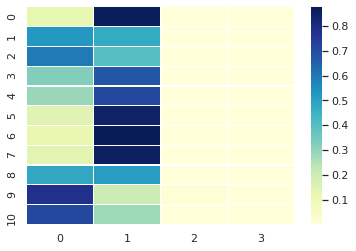

source:  applying vaccine at the time of measles 
actual:  <sos> खसरे का समय पर टीका लगाना ।
predicted:  खसरे का समय पर बना है । <eos>
BLEU Score:  0.19913749124569236


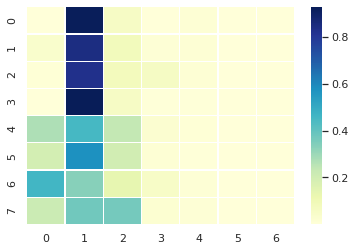

source:  giving doses of vitamina lrb  mn i   rrb during measles and at an interval of  months till  years lrb  mn i   rrb 
actual:  <sos> विटामिनए की खुराक   लाख आईयू   खसरे के टीके समय तथा  वर्ष तक   लाख आईयू   माह के अन्तराल पर देना ।
predicted:  विटामिनए की खुराक लाख आईयू खसरे के टीके समय तथा वर्ष तक लाख आईयू माह के अन्तराल पर देना । <eos>
BLEU Score:  0.17261970532895454


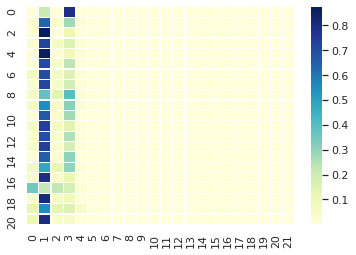

source:  it is necessary that children are given nutritious food so that they are saved from the malnutrition caused corneal blindness 
actual:  <sos> बच्चों को पौष्टिक आहार दिये जाने की आवश्यकता है ताकि कुपोषण से होने वाले कॉर्नियल ब्लाइन्डनेस से बचाया जा सकें ।
predicted:  बच्चों को पौष्टिक आहार दिये जाने की आवश्यकता है ताकि कुपोषण से होने वाले कॉर्नियल ब्लाइन्डनेस से बचाया जा सकें । <eos>
BLEU Score:  0.18068537884315472


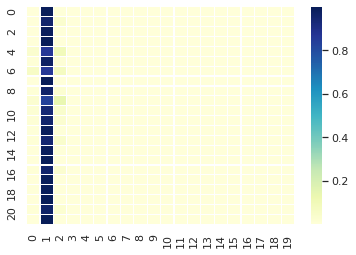

source:  for conjunctival cataract caused by rubella vaccination is required on time 
actual:  <sos> रूबेला के कारण होने वाले कन्जानाईटल कैटरेक्ट के लिये समय पर टीकाकरण किये जाने की आवश्यकता है ।
predicted:  रूबेला के कारण होने वाले कन्जानाईटल कैटरेक्ट के लिये किये जाने की आवश्यकता है । <eos>
BLEU Score:  0.18429333166740366


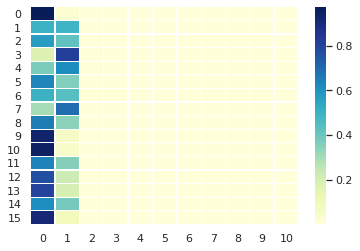

source:  about  to  percent of children become blind with one eye due to injuries in the eyes 
actual:  <sos> आँखों में चोट के लगने के कारण लगभग  से  प्रतिशत बच्चें एक आँख से अन्धे हो जाते हैं ।
predicted:  आँखों में चोट के लगने के कारण लगभग से प्रतिशत बच्चें पर नही हैं । <eos>
BLEU Score:  0.18068537884315472


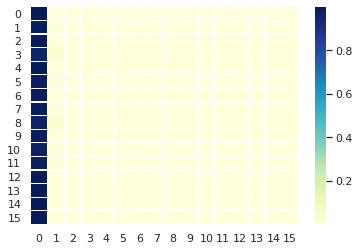

source:  it is required that people are educated about the safety of eyes so that blindness caused by crackers  industrial accidents and road traffic accidents could be escaped 
actual:  <sos> आँखों की सुरक्षा के बारे में लोगों को शिक्षित किये जाने की आवश्यकता है ताकि पटाखें औद्योगिक दुर्घटनायें एवं रोड ट्रेफिक दुर्घटनायों से होने वाली अन्धता को बचाया जा सके ।
predicted:  आँखों की सुरक्षा के बारे में लोगों को शिक्षित किये जाने की आवश्यकता है ताकि पटाखें औद्योगिक दुर्घटनायें एवं रोड ट्रेफिक दुर्घटनायों से होने वाली अन्धता को बचाया जा सके । <eos>
BLEU Score:  0.17089108973983766


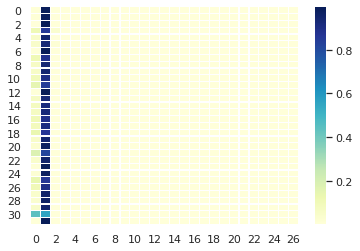

source:  to save eyes from diseases it is necessary to pay attention towards environmental sanitation and treatment is needed on time 
actual:  <sos> रोगों से आँखों के बचाव के लिये environmental senitation की ओर ध्यान दिये जाने की आवश्यकता है तथा उपचार समय पर किये जाने की जरूरत है ।
predicted:  रोगों से आँखों के बचाव के लिये environmental senitation की ओर ध्यान दिये जाने की आवश्यकता है तथा उपचार समय पर किये जाने की जरूरत है । <eos>
BLEU Score:  0.17445211157624774


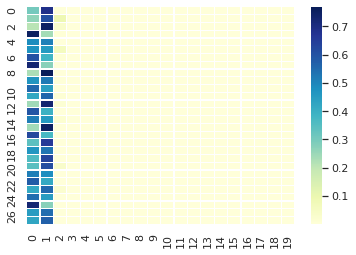

source:  gradual and painless lessening of vision in one or both of the eyes in a month or year 
actual:  <sos> धीरेधीरे तथा बिना दर्द के एक या दोनों आँखों में एक माह या वर्ष में दृष्टि में धीरेधीरे कमी आना ।
predicted:  धीरेधीरे तथा बिना दर्द के एक या दोनों आँखों में एक माह या वर्ष में दृष्टि में धीरेधीरे कमी आना । <eos>
BLEU Score:  0.18068537884315472


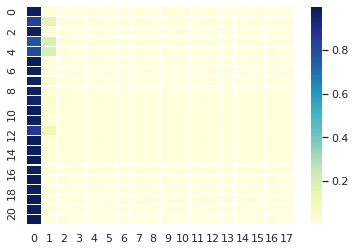

source:  pupil getting gray or white 
actual:  <sos> भूरा  gray  या सफेद पुतली  प्यूपिल  होना ।
predicted:  चने की जाँच होती है । <eos>
BLEU Score:  0.19259074009082888


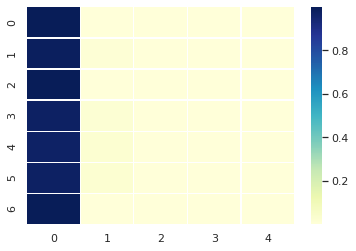

source:  when the rays of light do not fall on the retina or falls at the front or back of the retina 
actual:  <sos> जब प्रकाश की किरणें दृष्टि पटल  रेटिना  पर नही पड़ती हैं या तो रेटिना के आगे या रेटिना के पीछे पड़ती है ।
predicted:  जब प्रकाश की किरणें रेटिना से पहले एकत्रित हो जाती हैं । <eos>
BLEU Score:  0.17639910709395284


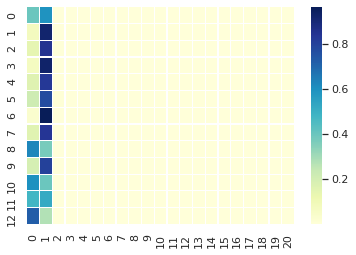

source:  when the rays of light gets collected before the retina 
actual:  <sos> जब प्रकाश की किरणें रेटिना से पहले एकत्रित हो जाती हैं ।
predicted:  जब प्रकाश की किरणें रेटिना से पहले पड़ती है । <eos>
BLEU Score:  0.19259074009082888


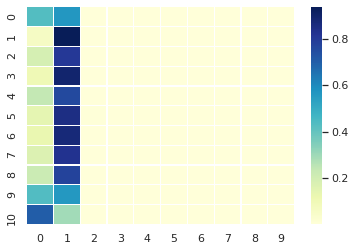

source:  fungus is also a kind of being that lives in our body and harms our body 
actual:  <sos> फंगस भी हमारे शरीर में रहने वाला ऐसा एक जीव है जो हमारे शरीर को नुकसान पहुँचाता है ।
predicted:  फंगस भी हमारे शरीर में रहने वाला ऐसा एक जीव है जो हमारे शरीर को नुकसान पहुँचाता है । <eos>
BLEU Score:  0.18305025818318518


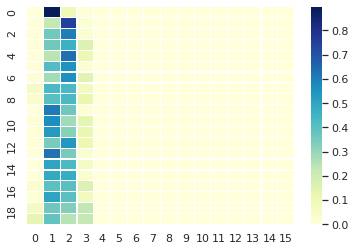

source:  fungus creates its abode in damped places like under the nail of our toe 
actual:  <sos> फंगस नमी वाली जगह जैसे हमारे पैर के अंगूठे के नाखून के नीचे अपना घर बना लेते हैं ।
predicted:  फंगस नमी वाली जगह जैसे हमारे पैर के अंगूठे के नाखून के नीचे अपना घर बना लेते हैं । <eos>
BLEU Score:  0.18305025818318518


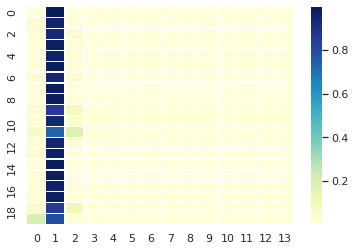

source:  it is called onikomysis 
actual:  <sos> जिसे ओनिकोमाइसिस कहते हैं ।
predicted:  जिसे में कहते हैं । <eos>
BLEU Score:  0.19879212680993805


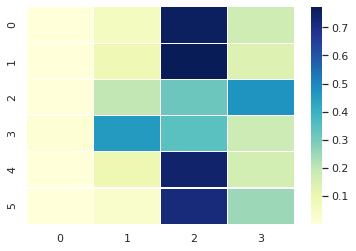

source:  the patient can see nearby things clearly but there occurs problem seeing things at a distance 
actual:  <sos> मरीज नजदीक की चीजें साफ देख सकता है परन्तु दूर की चीजें देखने में परेशानी होती है ।
predicted:  मरीज नजदीक की चीजें साफ देख सकता है परन्तु दूर की चीजें देखने में परेशानी होती है । <eos>
BLEU Score:  0.18429333166740366


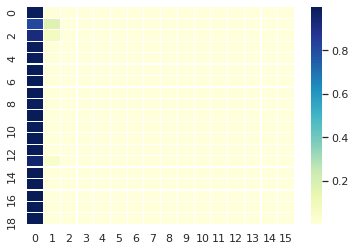

source:  the patient brings things near to the eyes to see things clearly 
actual:  <sos> मरीज चीजों को देखने के लिये आँख के पास लाता है ।
predicted:  मरीज चीजों को देखने के लिये आँख के पास लाता है । <eos>
BLEU Score:  0.19259074009082888


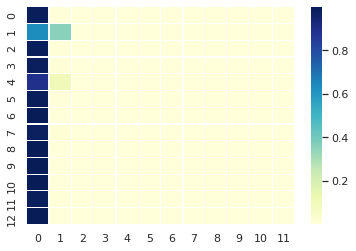

source:  student tries to sit very near to the blackboard in the classroom 
actual:  <sos> क्लास में विद्यार्थी श्यामपट के काफी नजदीक बैठने की कोशिश करता हैं ।
predicted:  क्लास में विद्यार्थी श्यामपट के काफी नजदीक बैठने की क्षमता की जाँच होती है । <eos>
BLEU Score:  0.19112328397109352


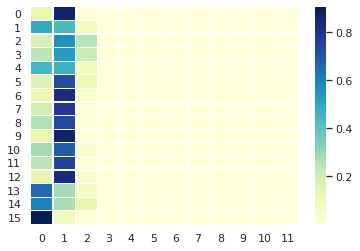

source:  when the rays of light collects at the back of the eye  this is seen mostly in the young children 
actual:  <sos> जब प्रकाश की किरणें रेटिना के पीछे एकत्रित होती है यह ज्यादातर जवान बच्चों में देखा जाता है ।
predicted:  जब प्रकाश की किरणें रेटिना के पीछे एकत्रित होती है यह ज्यादातर जवान बच्चों में देखा जाता है । <eos>
BLEU Score:  0.18305025818318518


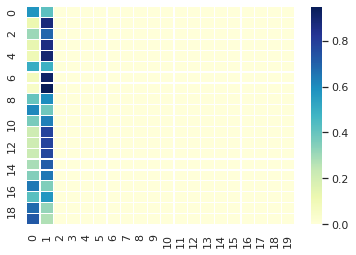

source:  headache  heaviness in the eyes  problem in reading 
actual:  <sos> सिर दर्द  आँखों में भारीपन  पढ़ने में परेशानी ।
predicted:  सिर दर्द आँखों में परेशानी । <eos>
BLEU Score:  0.1940679506664638


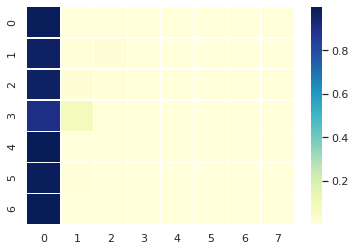

source:  due to weakness in the muscles of the eyes lens can not change its shape  the rays of light falls behind the retina while reading or doing things at a close distance  this is found at an age of  years or above 
actual:  <sos> आँख की मांसपेशियों की कमजोरी के कारण लैन्स अपना आकार नही बदल पाता पढ़ते या नजदीकी काम करते समय प्रकाश की किरणें रेटिना के पीछे पड़ती हैं यह  वर्ष और उससे ऊपर की उम्र में पाई जाती है ।
predicted:  आँख की मांसपेशियों की कमजोरी के कारण लैन्स अपना आकार नही बदल पाता पढ़ते या नजदीकी काम करते समय प्रकाश की किरणें रेटिना के पीछे पड़ती हैं यह वर्ष और उससे ऊपर की उम्र में पाई जाती है । <eos>
BLEU Score:  0.1641621938493551


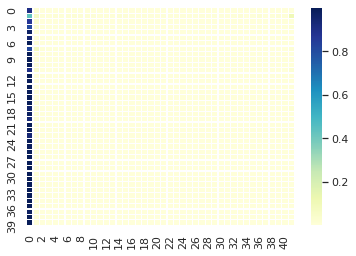

source:  shadowiness in readingwriting at a distance or doing things nearby 
actual:  <sos> दूर पढ़नेलिखने व कोई भी नजदीकी काम करने में धुंधलापन ।
predicted:  दूर पढ़नेलिखने व कोई भी नजदीकी काम करने में धुंधलापन । <eos>
BLEU Score:  0.2307869877265558


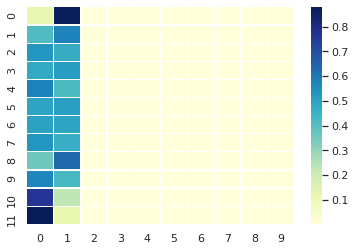

source:  if a ray of light can not concentrate at the front or back of the eye it causes shadowiness 
actual:  <sos> यदि कोई रोशनी की किरण आँख के पर्दे के आगे या पीछे किसी एक बिन्दु पर केन्द्रित नही हो पाती जिससे कि धुंधला दिखता है ।
predicted:  यदि कोई रोशनी की किरण आँख के पर्दे के आगे या पीछे किसी को की आगे या पीछे किसी की आगे हो पाती जिससे कि धुंधला दिखता है । <eos>
BLEU Score:  0.17541056564995905


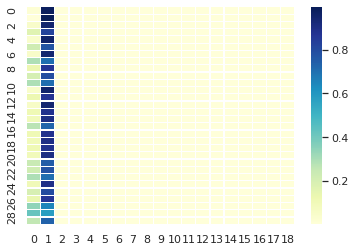

source:  shadowiness in seeing things nearby or at a distance  headache  reddening of eyes 
actual:  <sos> दूर अथवा नजदीक देखने में धुंधलापन सर में दर्द होना आँख का लाल होना ।
predicted:  दूर अथवा नजदीक देखने में धुंधलापन सर में दर्द होना आँख का लाल होना । <eos>
BLEU Score:  0.18827362913939635


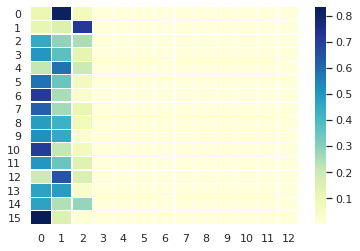

source:  cylindrical glasses have to be worn always 
actual:  <sos> सिलिंडरिकल ग्लासेस को हमेशा पहनना है ।
predicted:  सिलिंडरिकल ग्लासेस को हमेशा होता है । <eos>
BLEU Score:  0.19913749124569236


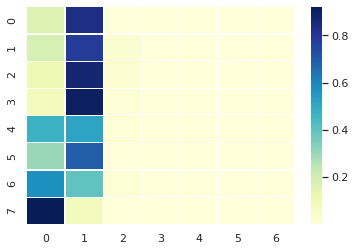

source:  cancer is a lifestyle generated disease 
actual:  <sos> कैंसर एक जीवन शैली से उत्पन्न होने वाली बीमारी है ।
predicted:  कैंसर एक जीवन शैली से उत्पन्न होता है । <eos>
BLEU Score:  0.1940679506664638


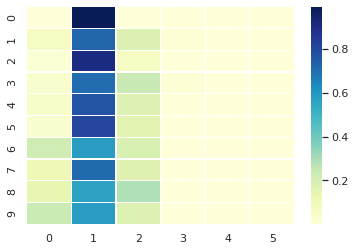

source:  cancer erupts by our wrong practices  thoughts  behavior and diet 
actual:  <sos> कैंसर हमारे गलत अचार  विचार व्यवहार और आहार से उत्पन्न होता है ।
predicted:  कैंसर हमारे गलत अचार विचार व्यवहार और आहार से उत्पन्न होता है । <eos>
BLEU Score:  0.18968126713037053


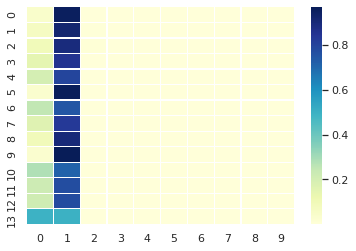

source:  smoking excessive cigarette causes more of windpipe cancer 
actual:  <sos> अधिक सिगरेट पीने से फेफड़ों  स्वॉस की नलियों का कैंसर अधिक होता है ।
predicted:  अधिक सिगरेट पीने से फेफड़ों होता है । <eos>
BLEU Score:  0.18827362913939635


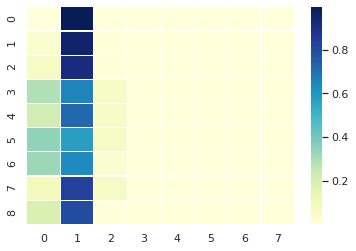

source:  we progress towards development and getting rid of diseases 
actual:  <sos> जैसेजैसे हम विकास की ओर अग्रसर हो रहे है एवं संक्रामक रोगों पर निजात पा रहे हैं ।
predicted:  जैसेजैसे हम विकास की चीजें बच्चें की चीजें ऐसा देते हैं । <eos>
BLEU Score:  0.18429333166740366


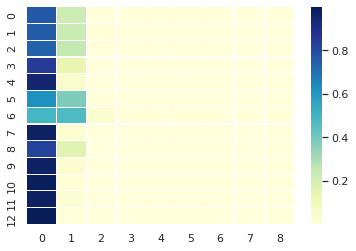

source:  due to changes in our lifestyle the number of cancer and heart patients are increasing 
actual:  <sos> वैसेवैसे अपने जीवन की शैली में बदलाव के कारण कैंसर व हदय रोगियों की संख्या में वृद्धि हो रही है ।
predicted:  वैसेवैसे अपने जीवन की शैली में बदलाव के कारण कैंसर व हदय रोगियों की नली का कैंसर अधिक पाया जाता है तथा गुटका पान पराग खैनी सुरती से मुँह व पेट का कैंसर होने की अधिक सम्भावना पायी गयी है
BLEU Score:  0.17956076853248887


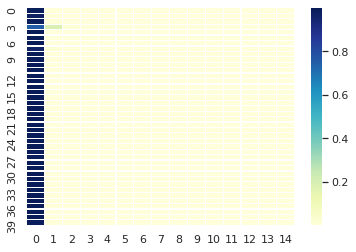

source:  this disease is number one in japan  in developed countries  this disease in at number  and in developing countries this disease is at number  
actual:  <sos> जापान में यह बीमारी नम्बर एक पर है विकसित देशों में यह बीमारी दूसरे नम्बर पर  और विकासशील देशों में यह तीसरे नम्बर पर है ।
predicted:  जापान में यह बीमारी नम्बर एक पर है विकसित देशों में यह बीमारी दूसरे नम्बर पर और विकासशील देशों में यह तीसरे नम्बर पर है । <eos>
BLEU Score:  0.17445211157624774


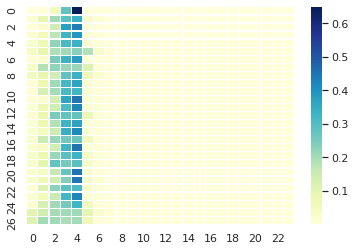

source:  one out of every eight persons can at any time become victim of cancer 
actual:  <sos> भारत में आठ में से एक व्यक्ति अपने उमर में कभी भी कैंसर से पीड़ित हो सकता है ।
predicted:  भारत में आठ में से एक व्यक्ति अपने वाला ऐसा होता है । <eos>
BLEU Score:  0.18305025818318518


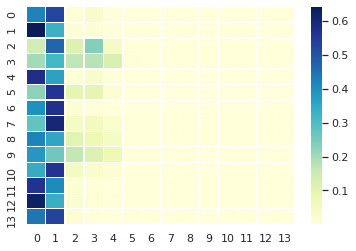

source:  this disease found in different types at different locations in our country due to difference in the lifestyle  customs and religion 
actual:  <sos> हमारे देश में जीवन शैली  रीतीरीवाज  धर्म भिन्न होने के कारण यह बीमारी अलगअलग जगह में विभिन्न प्रकार से पायी जाती है ।
predicted:  हमारे देश में जीवन शैली रीतीरीवाज धर्म भिन्न होने के कारण यह बीमारी अलगअलग जगह में विभिन्न प्रकार से पायी जाती है । <eos>
BLEU Score:  0.17639910709395284


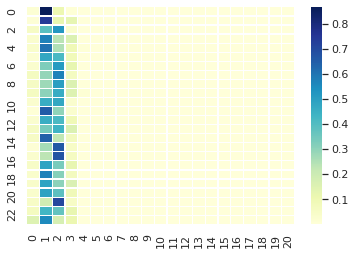

source:  all the data in the country has been calculated  ovarian cancer and breast cancer is found in  percent of the women in cities 
actual:  <sos> देश के सभी आंकडों का आंकलन कर देखा गया है शहरों में  प्रतिशत महिलाओं में बच्चेदानी के मुँह का कैंसर व स्तन कैंसर पाये जाते हैं ।
predicted:  देश के सभी आंकडों का आंकलन कर देखा गया है । <eos>
BLEU Score:  0.17352228696404481


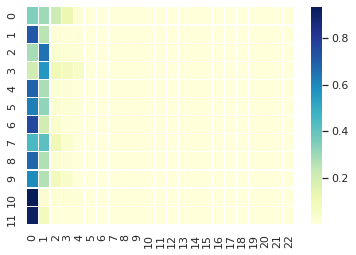

source:  it is between  and  percent among the rural women 
actual:  <sos> ग्रामीण महिलाओं में यह दोनों  से  प्रतिशत के बीच में है ।
predicted:  ग्रामीण महिलाओं में यह दोनों से प्रतिशत शिक्षित किये जाने की आवश्यकता है ताकि पटाखें औद्योगिक दुर्घटनायें एवं रोड ट्रेफिक दुर्घटनायों से होने वाली अन्धता को बचाया जा सके । <eos>
BLEU Score:  0.18968126713037053


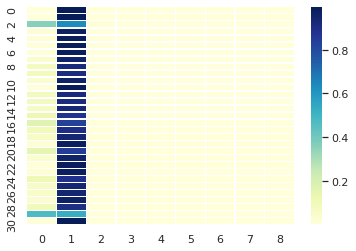

source:  lungs and breathing pipe cancer is found more due to smoking and pollution and the possibility of cancer of the mouth and stomach is more with gutkha  pan parag  tobacco and tobacco powder 
actual:  <sos> पुरूषों में धूम्रपान एवं प्रदूषण से फेफड़े व श्वाँस साँस की नली का कैंसर अधिक पाया जाता है तथा गुटका  पान पराग  खैनी  सुरती से मुँह व पेट का कैंसर होने की अधिक सम्भावना पायी गयी है ।
predicted:  पुरूषों में धूम्रपान एवं प्रदूषण से फेफड़े व श्वाँस साँस की नली का कैंसर अधिक पाया जाता है तथा गुटका पान पराग खैनी सुरती से मुँह व पेट का कैंसर होने की अधिक सम्भावना पायी गयी है । <eos>
BLEU Score:  0.1944387569440379


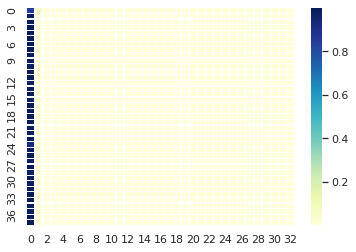

source:  what is cancer 
actual:  <sos> कैंसर क्या है 
predicted:  चौलाई सेवन <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
BLEU Score:  0


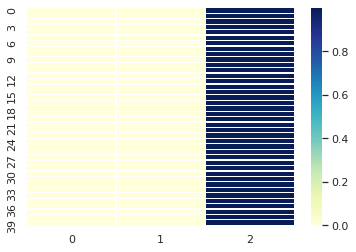

source:  cancer is name of a disease 
actual:  <sos> कैंसर एक बीमारी का नाम है ।
predicted:  कैंसर शरीर में अन्तराल पर और विकासशील देशों में यह बीमारी हैं । <eos>
BLEU Score:  0.19913749124569236


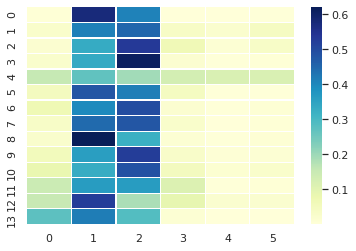

source:  in cancer cells multiply by itself and ignores the rules of the body 
actual:  <sos> कैंसर में शरीर में कोशिका अपने आप ही गुणात्मक तरीके से वृद्वि करती है और शरीर के नियमों को अनदेखा करती है ।
predicted:  कैंसर में शरीर में कोशिका अपने आप किया जाता है । <eos>
BLEU Score:  0.17847260705223245


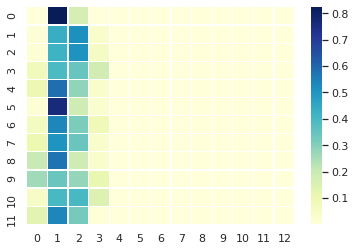

source:  cells also reach other parts of the body 
actual:  <sos> कोशिका शरीर के दूसरे भागों में भी पहुँच जाती है ।
predicted:  कोशिका शरीर के आगे किया जाता है । <eos>
BLEU Score:  0.1940679506664638


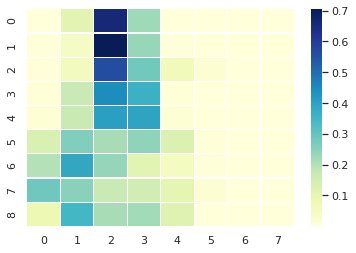

source:  cell takes the form of a cyst or wound  and destroys all the systems coming in contact with it 
actual:  <sos> कोशिका एक गिल्टी या घाव का रूप ले लेती है  और अपने सम्पर्क में आने वाली सभी तन्त्रों को नष्ट कर देती है ।
predicted:  कोशिका एक गिल्टी या घाव का रूप ले लेती है और अपने सम्पर्क में आने वाली सभी तन्त्रों को नष्ट कर देती है । <eos>
BLEU Score:  0.17639910709395284


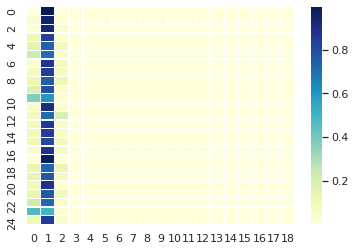

source:  cancer is a group of more than  diseases 
actual:  <sos> कैंसर  से अधिक बीमारीयों का एक समूह है ।
predicted:  कैंसर से अधिक होने वाली बीमारी है । <eos>
BLEU Score:  0.19552795980276136


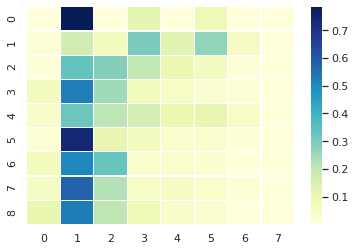

source:  although each of the disease is different from the other but basically all the types of cancers occurs as a result of anomaly in some cells 
actual:  <sos> हालांकि हर बीमारी एक दूसरे से काफी भिन्न होती है  परन्तु मूलतः सभी कैंसर शरीर की कुछ कोशिकाओं में अव्यवस्था के परिणामस्वरुप होते हैं ।
predicted:  हालांकि हर बीमारी एक दूसरे से काफी भिन्न होती है परन्तु मूलतः सभी कैंसर शरीर की कुछ कोशिकाओं में अव्यवस्था के परिणामस्वरुप होते हैं । <eos>
BLEU Score:  0.17541056564995905


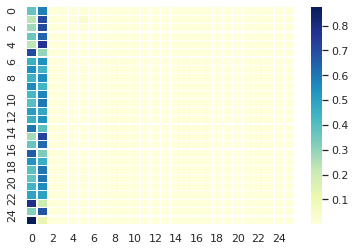

source:  generally  easy tumors can be weeded out through surgery and there is no possibility of its coming up again 
actual:  <sos> सामान्यतः सुसाध्य ट्यूमरों को शल्यचिकित्सा द्वारा निकाला जा सकता है और इनके फिर से होने की संभावना नही होती ।
predicted:  सामान्यतः सुसाध्य ट्यूमरों को शल्यचिकित्सा द्वारा निकाला जा सकता है और इनके फिर से होने की संभावना नही होती । <eos>
BLEU Score:  0.18184804078107475


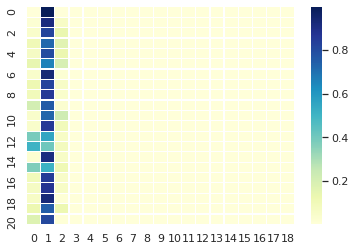

source:  difficult tumors are cancer 
actual:  <sos> असाध्य ट्यूमर कैंसर होते हैं ।
predicted:  असाध्य ट्यूमर हैं । <eos>
BLEU Score:  0.19953087735062713


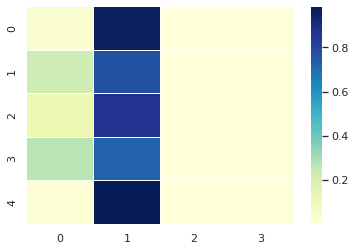

source:  difficult tumors can destroy nearby tissues and parts 
actual:  <sos> असाध्य ट्यूमर निकट के ऊतकों और अंगों को नष्ट कर सकते हैं ।
predicted:  असाध्य ट्यूमर निकट के ऊतकों <eos>
BLEU Score:  0


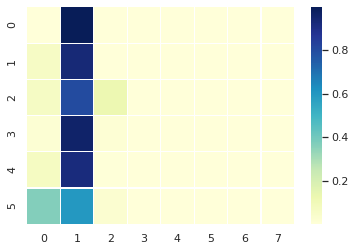

source:  cancer cells can spread into other areas through which new tumors can get born 
actual:  <sos> कैंसर की कोशिकाएँ शरीर के अन्य भागों में फैल सकती हैं या रोगव्यापि कर सकती हैं  जिससे नए ट्यूमर पैदा हो सकते हैं ।
predicted:  कैंसर की कोशिकाएँ शरीर के अन्य भागों में फैल सकती हैं । <eos>
BLEU Score:  0.17639910709395284


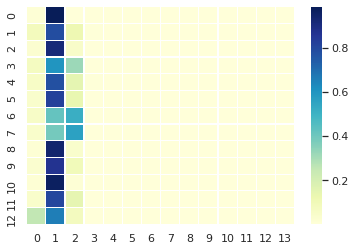

source:  as cancer can spread  it is necessary that the doctor should immediately find whether the tumor is formed and that it is cancer 
actual:  <sos> कैंसर चूँकि फैल सकता है  अतः आवश्यक है कि चिकित्सक तुरन्त यह पता कर लें कि क्या ट्यूमर बन गया है  और यह कैंसर है ।
predicted:  कैंसर चूँकि फैल सकता है अतः आवश्यक है कि चिकित्सक तुरन्त यह पता कर लें कि क्या ट्यूमर बन गया है और यह कैंसर है । <eos>
BLEU Score:  0.17352228696404481


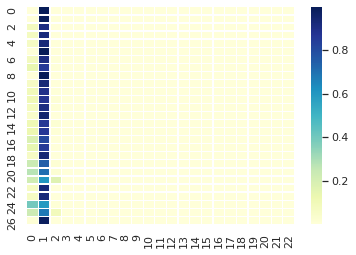

source:  the treatment of cancer can start as soon as it is found 
actual:  <sos> कैंसर का पता चलते ही इसका इलाज आरम्भ किया जा सकता है ।
predicted:  कैंसर का पता चलते ही इसका इलाज आरम्भ किया जा सकता है । <eos>
BLEU Score:  0.19112328397109352


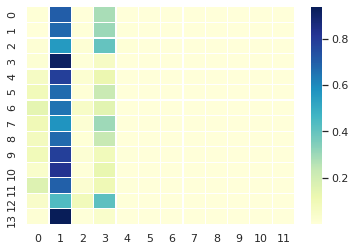

source:  several symptoms shows up due to cancer that gives the impressions of cancer 
actual:  <sos> कैंसर के कारण ऐसे अनेक लक्षण दिखलाई पड़ने लगते हैं जो कैंसर होने का आभास देते हैं ।
predicted:  कैंसर के कारण ऐसे अनेक लक्षण दिखलाई पड़ने लगते हैं जो कैंसर होने का आभास देते हैं । <eos>
BLEU Score:  0.18429333166740366


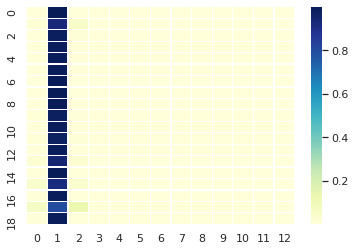

source:  details of some important symptoms are given below 
actual:  <sos> कुछ महत्वपूर्ण लक्षणों का विवरण नीचे दिया जा रहा है ।
predicted:  कुछ महत्वपूर्ण लक्षणों का विवरण नीचे दिया जा रहा है । <eos>
BLEU Score:  0.1940679506664638


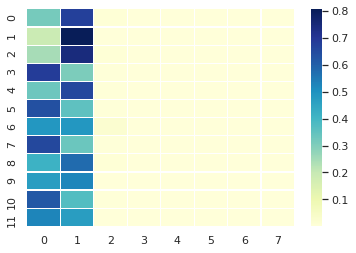

source:  if there is an oxalate stone in the kidney what preventions could be advantageous 
actual:  <sos> गुर्दे में ऑक्जेलेट पत्थरी रही हो तो आगे किनकिन चीजों से परहेज बरतना फायदेमंद हो सकता है 
predicted:  गुर्दे में ऑक्जेलेट पत्थरी रही हो तो आगे किनकिन चीजों से परहेज बरतना फायदेमंद हो सकता है <eos>
BLEU Score:  0


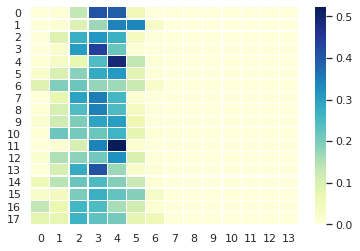

source:  any wound that do not heal in enough time 
actual:  <sos> कोई भी घाव जो काफी समय से भरता नहीं हो ।
predicted:  कोई भी घाव जो काफी समय से भरता नहीं हो । <eos>
BLEU Score:  0.1940679506664638


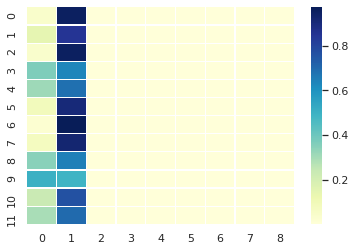

In [48]:
model = {"encoder":encoder,"decoder":decoder}
# get_prediction(X_test,y_in_test)
get_prediction(X_train,y_in_train, model)